In [35]:
# Anomaly Detection for Cybersecurity - Model Comparison
# Research Project: Predicting Cybersecurity Attacks Using Compound Analysis

In [36]:
# Try this in a Colab cell:
!pip install tensorflow
# Then restart runtime: Runtime > Restart Runtime

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, precision_recall_curve, f1_score, accuracy_score,
                           precision_score, recall_score)
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

# For neural network-based anomaly detection
try:
    from tensorflow.keras.models import Model, Sequential
    from tensorflow.keras.layers import Input, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
    TENSORFLOW_AVAILABLE = True
except ImportError:
    print("TensorFlow not available. Autoencoder models will be skipped.")
    TENSORFLOW_AVAILABLE = False

# Set random seeds for reproducibility
np.random.seed(42)
if TENSORFLOW_AVAILABLE:
    import tensorflow as tf
    tf.random.set_seed(42)

print("All required libraries imported successfully!")
print("=" * 60)

All required libraries imported successfully!


In [38]:
## 1. Data Loading and Initial Setup

def load_data_from_drive():
    """
    Load dataset from Google Drive CSV file
    Note: Make sure the CSV file is uploaded to your Colab environment
    """
    try:
        # Option 1: If using Google Colab, mount drive
        from google.colab import drive
        drive.mount('/content/drive')

        # Update this path to your actual CSV file location
        # Common paths in Google Drive:
        # '/content/drive/MyDrive/your_dataset.csv'
        # '/content/drive/MyDrive/Colab Notebooks/your_dataset.csv'
        file_path = '/content/drive/MyDrive/FYP - Source/extracted_dataset.csv'  # Update this path

        print(f"Loading data from: {file_path}")
        df = pd.read_csv(file_path)
        print(f"Successfully loaded dataset with shape: {df.shape}")

        return df

    except FileNotFoundError:
        print(f"File not found at: {file_path}")
        print("Please update the file_path variable with the correct path to your CSV file")
        print("You can also upload the file directly to Colab:")
        print("1. Click the folder icon on the left sidebar")
        print("2. Upload your CSV file")
        print("3. Update the file_path to '/content/your_filename.csv'")
        return None

    except Exception as e:
        print(f"Error loading from Google Drive: {e}")
        print("Alternative: Upload file directly to Colab session")

        # Option 2: Direct file upload to Colab session
        try:
            from google.colab import files
            print("Please upload your CSV file:")
            uploaded = files.upload()

            if uploaded:
                filename = list(uploaded.keys())[0]
                df = pd.read_csv(filename)
                print(f"Successfully loaded uploaded file with shape: {df.shape}")
                return df
            else:
                print("No file uploaded")
                return None

        except Exception as upload_error:
            print(f"Upload error: {upload_error}")
            return None

def create_sample_dataset():
    """
    Create a sample dataset for demonstration purposes - NOT USED with real data
    This simulates web application log features
    """
    print("Note: This function creates sample data for demonstration.")
    print("Your real dataset will be loaded using load_data_from_drive()")
    return None

# Load the dataset
print("Loading dataset...")
df = load_data_from_drive()
print(f"Dataset loaded successfully! Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())


Loading dataset...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from: /content/drive/MyDrive/FYP - Source/extracted_dataset.csv
Successfully loaded dataset with shape: (2500, 38)
Dataset loaded successfully! Shape: (2500, 38)

First few rows:
                    uid       ts        id.orig_h        id.resp_h service  \
0  b_CfXdFr3sW9WsL5f6uf  17:29.1  192.168.100.115  192.168.100.209     dns   
1  b_CL7sGY2RVAyREp3Am4  17:29.1  192.168.100.115  192.168.100.209     dns   
2  b_C5f3vd3d5SrErNlLo3  17:29.2   192.168.100.49  192.168.100.209     dns   
3   b_CsFkinVMGxastE8Lf  17:29.2   192.168.100.49  192.168.100.209     dns   
4   b_CUi4ud060SmDrSaxf  17:29.2  192.168.100.104  192.168.100.209     dns   

   flow_duration  fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  \
0       0.009682             2             2                  2   
1       0.009523             2             2             

In [47]:
## 3. Fixed Data Preprocessing and Feature Engineering

def preprocess_data(df):
    """
    FIXED VERSION: Preprocess the data for anomaly detection with proper label handling
    """
    print("=" * 60)
    print("DATA PREPROCESSING - FIXED VERSION")
    print("=" * 60)

    # Display basic information about the dataset
    print("Dataset Info:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isnull().sum())

    # Handle missing values
    df = df.dropna()
    print(f"\nAfter removing missing values: {df.shape}")

    # Identify and handle categorical columns
    categorical_columns = ['uid', 'ts', 'id.orig_h', 'id.resp_h', 'service', 'traffic_direction']
    label_columns = ['attack', 'attack_type']

    # Remove non-feature columns (identifiers and timestamps)
    columns_to_remove = ['uid', 'ts', 'id.orig_h', 'id.resp_h']
    df_processed = df.drop(columns=[col for col in columns_to_remove if col in df.columns])

    print(f"\nAfter removing identifier columns: {df_processed.shape}")

    # Encode categorical features
    le_encoders = {}
    categorical_features = ['service', 'traffic_direction']

    for col in categorical_features:
        if col in df_processed.columns:
            le = LabelEncoder()
            # Handle missing values in categorical columns
            df_processed[col] = df_processed[col].fillna('unknown')
            df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col].astype(str))
            le_encoders[col] = le
            df_processed = df_processed.drop(col, axis=1)
            print(f"Encoded {col} -> {col}_encoded")

    # FIXED LABEL HANDLING - This is the critical fix!
    y_binary = None
    if 'attack' in df_processed.columns:
        print(f"\nAttack distribution:")
        attack_counts = df_processed['attack'].value_counts()
        print(attack_counts)

        # Check what attack types we have
        unique_attacks = df_processed['attack'].unique()
        print(f"Unique attack types found: {unique_attacks}")

        # FIXED: Create binary labels properly based on actual data
        if 'attack' in unique_attacks and 'benign' in unique_attacks:
            # We have both 'attack' and 'benign' labels
            y_binary = (df_processed['attack'] == 'attack').astype(int)
        elif 'normal' in unique_attacks:
            # We have 'normal' instead of 'benign'
            y_binary = (df_processed['attack'] != 'normal').astype(int)
        elif len(unique_attacks) == 1:
            # Only one type - create synthetic labels for testing
            print("⚠️  Only one attack type found - creating synthetic anomalies for testing")
            y_binary = np.zeros(len(df_processed))
            # Mark 10% as anomalies randomly for testing
            anomaly_indices = np.random.choice(len(df_processed), size=int(0.1 * len(df_processed)), replace=False)
            y_binary[anomaly_indices] = 1
            y_binary = y_binary.astype(int)
        else:
            # Multiple attack types - treat non-benign as attacks
            benign_labels = ['benign', 'normal', 'legitimate']
            y_binary = (~df_processed['attack'].isin(benign_labels)).astype(int)

        print(f"\nBinary label distribution:")
        print(f"Normal samples (y=0): {sum(y_binary == 0)}")
        print(f"Attack samples (y=1): {sum(y_binary == 1)}")
        print(f"Attack percentage: {sum(y_binary == 1) / len(y_binary) * 100:.2f}%")

        # Remove label columns from features
        X = df_processed.drop(['attack', 'attack_type'], axis=1, errors='ignore')

    elif 'attack_type' in df_processed.columns:
        # If only attack_type is available
        print(f"\nAttack type distribution:")
        attack_type_counts = df_processed['attack_type'].value_counts()
        print(attack_type_counts)

        unique_attack_types = df_processed['attack_type'].unique()
        print(f"Unique attack types: {unique_attack_types}")

        # Create binary labels based on attack_type
        benign_labels = ['benign', 'normal', 'legitimate']
        y_binary = (~df_processed['attack_type'].isin(benign_labels)).astype(int)

        print(f"\nBinary label distribution:")
        print(f"Normal samples (y=0): {sum(y_binary == 0)}")
        print(f"Attack samples (y=1): {sum(y_binary == 1)}")
        print(f"Attack percentage: {sum(y_binary == 1) / len(y_binary) * 100:.2f}%")

        # Remove label column from features
        X = df_processed.drop(['attack_type'], axis=1, errors='ignore')

    else:
        X = df_processed
        y_binary = None
        print("\nNo attack labels found. Assuming unsupervised anomaly detection.")

    # Enhanced Feature Engineering
    print("\nPerforming feature engineering...")
    X = engineer_additional_features(X)

    # Ensure all features are numeric
    print(f"\nFeature columns after preprocessing:")
    print(f"Shape: {X.shape}")
    print(f"Columns: {list(X.columns)}")

    # Check for any remaining non-numeric columns
    non_numeric_cols = X.select_dtypes(include=['object']).columns.tolist()
    if non_numeric_cols:
        print(f"\nWarning: Non-numeric columns found: {non_numeric_cols}")
        print("Converting to numeric or dropping...")

        for col in non_numeric_cols:
            try:
                # Try to convert to numeric
                X[col] = pd.to_numeric(X[col], errors='coerce')
                print(f"Converted {col} to numeric")
            except:
                # If conversion fails, encode as categorical
                le = LabelEncoder()
                X[f'{col}_encoded'] = le.fit_transform(X[col].astype(str))
                X = X.drop(col, axis=1)
                print(f"Encoded {col} as categorical")

    # Handle any infinite values
    X = X.replace([np.inf, -np.inf], np.nan)

    # Fill any remaining NaN values with median for numeric columns
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].median())

    print(f"\nFinal processed data shape: {X.shape}")
    print(f"Final feature columns: {list(X.columns)}")

    return X, y_binary

def engineer_additional_features(X):
    """
    Enhanced feature engineering for network flow data
    """
    print("Engineering additional features...")

    # Packet-based features
    if all(col in X.columns for col in ['fwd_pkts_tot', 'bwd_pkts_tot']):
        X['total_packets'] = X['fwd_pkts_tot'] + X['bwd_pkts_tot']
        X['fwd_bwd_pkt_ratio'] = X['fwd_pkts_tot'] / (X['bwd_pkts_tot'] + 1e-8)
        print("  Added packet ratio features")

    # Data packet features
    if all(col in X.columns for col in ['fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_pkts_tot', 'bwd_pkts_tot']):
        X['total_data_packets'] = X['fwd_data_pkts_tot'] + X['bwd_data_pkts_tot']
        X['data_pkt_ratio'] = X['total_data_packets'] / (X['total_packets'] + 1e-8)
        print("  Added data packet features")

    # Flow duration features
    if 'flow_duration' in X.columns and 'total_packets' in X.columns:
        X['packets_per_second'] = X['total_packets'] / (X['flow_duration'] + 1e-8)
        print("  Added flow rate features")

    # Header size features
    header_cols = [col for col in X.columns if 'header_size' in col]
    if header_cols:
        X['total_header_size'] = X[header_cols].sum(axis=1)
        X['avg_header_size'] = X[header_cols].mean(axis=1)
        print("  Added header size features")

    # Flag-based features
    flag_columns = [col for col in X.columns if 'flag_count' in col]
    if flag_columns:
        X['total_flags'] = X[flag_columns].sum(axis=1)
        X['flag_diversity'] = (X[flag_columns] > 0).sum(axis=1)
        print("  Added flag-based features")

    # Window size features
    window_cols = [col for col in X.columns if 'window_size' in col]
    if window_cols:
        X['avg_window_size'] = X[window_cols].mean(axis=1)
        print("  Added window size features")

    # Payload features
    if 'payload_bytes_per_second' in X.columns:
        # Create payload intensity categories
        X['payload_intensity'] = pd.cut(X['payload_bytes_per_second'],
                                      bins=5, labels=[0,1,2,3,4], include_lowest=True)
        X['payload_intensity'] = X['payload_intensity'].astype(float)
        print("  Added payload intensity features")

    # Statistical features for packet rates
    rate_cols = [col for col in X.columns if 'per_sec' in col]
    if rate_cols:
        X['max_rate'] = X[rate_cols].max(axis=1)
        X['min_rate'] = X[rate_cols].min(axis=1)
        X['rate_variance'] = X[rate_cols].var(axis=1)
        print("  Added statistical rate features")

    print(f"  Feature engineering complete. New shape: {X.shape}")
    return X

# FIXED: Preprocess the data with proper label handling
X, y = preprocess_data(df)

# FIXED: Handle the case where we have both normal and attack samples
if y is not None:
    print(f"\nLabel distribution analysis:")
    print(f"Normal samples (y=0): {sum(y == 0)}")
    print(f"Attack samples (y=1): {sum(y == 1)}")

    # Check if we have both classes for proper splitting
    unique_labels = np.unique(y)
    print(f"Unique labels: {unique_labels}")

    if len(unique_labels) > 1:
        # We have both normal and attack samples - do stratified split
        print("✅ Both normal and attack samples found - performing stratified split")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        # For anomaly detection, we typically train only on normal samples
        normal_mask = y_train == 0
        X_train_normal = X_train[normal_mask]
        X_test_full = X_test
        y_test_full = y_test

        print(f"Training set (normal only): {X_train_normal.shape}")
        print(f"Test set: {X_test_full.shape}")
        print(f"Normal samples in training: {sum(normal_mask)}")
        print(f"Attack samples in test: {sum(y_test_full == 1)}")

    else:
        # Only one class - do regular split
        print("⚠️  Only one class found. Using regular train-test split.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_train_normal = X_train  # All training data
        X_test_full = X_test
        y_test_full = y_test

else:
    # If no labels, use all data with simple split
    print("No labels found. Using 70-30 split for unsupervised learning.")
    train_size = int(0.7 * len(X))
    X_train_normal = X.iloc[:train_size]
    X_test_full = X.iloc[train_size:]
    y_test_full = None

    print(f"Training set: {X_train_normal.shape}")
    print(f"Test set: {X_test_full.shape}")

# FIXED: Feature scaling with proper error handling
if len(X_train_normal) > 0:
    print("\n🔧 Applying feature scaling...")
    scaler = StandardScaler()

    try:
        X_train_scaled = scaler.fit_transform(X_train_normal)
        X_test_scaled = scaler.transform(X_test_full)

        print("✅ Feature scaling completed successfully.")
        print(f"Scaled training data shape: {X_train_scaled.shape}")
        print(f"Scaled test data shape: {X_test_scaled.shape}")

        # Calculate contamination rate based on actual data
        if y_test_full is not None:
            contamination_rate = np.mean(y_test_full)
            # Bound contamination between 5% and 30%
            contamination_rate = max(0.05, min(0.30, contamination_rate))
            print(f"Calculated contamination rate: {contamination_rate:.3f}")
        else:
            contamination_rate = 0.1
            print(f"Using default contamination rate: {contamination_rate}")

    except Exception as e:
        print(f"❌ ERROR during feature scaling: {e}")
        X_train_scaled = None
        X_test_scaled = None
        contamination_rate = 0.1

else:
    print("\n❌ ERROR: No training data available for scaling!")
    print("This indicates a problem with the preprocessing or train-test split.")
    X_train_scaled = None
    X_test_scaled = None
    contamination_rate = 0.1

# Print summary for verification
print("\n" + "=" * 60)
print("PREPROCESSING SUMMARY")
print("=" * 60)
print(f"✅ Dataset shape after preprocessing: {X.shape}")
print(f"✅ Number of features: {X.shape[1]}")
if y is not None:
    print(f"✅ Label distribution: {dict(zip(*np.unique(y, return_counts=True)))}")
if X_train_scaled is not None:
    print(f"✅ Training data ready: {X_train_scaled.shape}")
    print(f"✅ Test data ready: {X_test_scaled.shape}")
    print(f"✅ Contamination rate: {contamination_rate:.3f}")
else:
    print("❌ Training data not ready - check preprocessing steps")
print("=" * 60)

DATA PREPROCESSING - FIXED VERSION
Dataset Info:
Shape: (2500, 38)
Columns: ['uid', 'ts', 'id.orig_h', 'id.resp_h', 'service', 'flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot', 'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot', 'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count', 'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count', 'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count', 'payload_bytes_per_second', 'fwd_init_window_size', 'bwd_init_window_size', 'fwd_last_window_size', 'bwd_last_window_size', 'traffic_direction', 'attack', 'attack_type']

Data types:
uid                          object
ts                           object
id.orig_h                    object
id.resp_h                    object
service      

In [48]:
## 3. Anomaly Detection Models

class AnomalyDetectorComparison:
    """
    Class to compare different anomaly detection models
    """

    def __init__(self):
        self.models = {}
        self.results = {}
        self.predictions = {}

    def add_model(self, name, model):
        """Add a model to the comparison"""
        self.models[name] = model

    def train_and_evaluate(self, X_train, X_test, y_test=None):
        """Train all models and evaluate their performance"""

        print("=" * 60)
        print("MODEL TRAINING AND EVALUATION")
        print("=" * 60)

        for name, model in self.models.items():
            print(f"\nTraining {name}...")

            try:
                # Train the model
                if hasattr(model, 'fit'):
                    model.fit(X_train)

                # Make predictions
                if hasattr(model, 'predict'):
                    predictions = model.predict(X_test)

                    # Convert predictions to binary format (1 for anomaly, 0 for normal)
                    if name in ['One-Class SVM', 'Isolation Forest', 'Elliptic Envelope']:
                        # These models return -1 for anomalies, 1 for normal
                        predictions_binary = (predictions == -1).astype(int)
                    elif name == 'Local Outlier Factor':
                        # LOF returns -1 for anomalies, 1 for normal
                        predictions_binary = (predictions == -1).astype(int)
                    elif name == 'DBSCAN':
                        # DBSCAN returns -1 for outliers (anomalies)
                        predictions_binary = (predictions == -1).astype(int)
                    else:
                        predictions_binary = predictions

                    self.predictions[name] = predictions_binary

                    # Calculate anomaly scores if available
                    if hasattr(model, 'decision_function'):
                        anomaly_scores = model.decision_function(X_test)
                        # For visualization, invert scores so higher = more anomalous
                        if name in ['One-Class SVM', 'Isolation Forest']:
                            anomaly_scores = -anomaly_scores
                    elif hasattr(model, 'score_samples'):
                        anomaly_scores = -model.score_samples(X_test)  # LOF returns negative scores
                    else:
                        anomaly_scores = None

                    # Evaluate if ground truth is available
                    if y_test is not None:
                        metrics = self.calculate_metrics(y_test, predictions_binary, anomaly_scores)
                        self.results[name] = metrics
                        self.print_results(name, metrics)
                    else:
                        print(f"Model {name} trained successfully. No ground truth for evaluation.")
                        anomaly_count = sum(predictions_binary)
                        print(f"Detected {anomaly_count} anomalies out of {len(predictions_binary)} samples")
                        print(f"Anomaly rate: {anomaly_count/len(predictions_binary)*100:.2f}%")

            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                self.results[name] = None

    def calculate_metrics(self, y_true, y_pred, anomaly_scores=None):
        """Calculate evaluation metrics"""
        metrics = {}

        # Basic classification metrics
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred, zero_division=0)
        metrics['recall'] = recall_score(y_true, y_pred, zero_division=0)
        metrics['f1'] = f1_score(y_true, y_pred, zero_division=0)

        # Calculate AUC if anomaly scores are available
        if anomaly_scores is not None:
            try:
                metrics['auc'] = roc_auc_score(y_true, anomaly_scores)
            except:
                metrics['auc'] = None
        else:
            metrics['auc'] = None

        return metrics

    def print_results(self, model_name, metrics):
        """Print evaluation results for a model"""
        print(f"\n{model_name} Results:")
        print(f"  Accuracy:  {metrics['accuracy']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1-Score:  {metrics['f1']:.4f}")
        if metrics['auc'] is not None:
            print(f"  AUC:       {metrics['auc']:.4f}")

# Initialize the comparison class
detector_comparison = AnomalyDetectorComparison()

# Add different anomaly detection models

# 1. One-Class SVM
print("Setting up One-Class SVM...")
oc_svm = OneClassSVM(gamma='scale', nu=0.1)  # nu is the expected proportion of outliers
detector_comparison.add_model('One-Class SVM', oc_svm)

# 2. Isolation Forest
print("Setting up Isolation Forest...")
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators=100)
detector_comparison.add_model('Isolation Forest', iso_forest)

# 3. Local Outlier Factor
print("Setting up Local Outlier Factor...")
lof = LocalOutlierFactor(contamination=0.1, novelty=True)
detector_comparison.add_model('Local Outlier Factor', lof)

# 4. Elliptic Envelope (Robust Covariance)
print("Setting up Elliptic Envelope...")
elliptic = EllipticEnvelope(contamination=0.1, random_state=42)
detector_comparison.add_model('Elliptic Envelope', elliptic)

# 5. DBSCAN (Clustering-based)
print("Setting up DBSCAN...")
dbscan = DBSCAN(eps=0.5, min_samples=5)
detector_comparison.add_model('DBSCAN', dbscan)

Setting up One-Class SVM...
Setting up Isolation Forest...
Setting up Local Outlier Factor...
Setting up Elliptic Envelope...
Setting up DBSCAN...


In [49]:
## 4. Autoencoder-based Anomaly Detection (if TensorFlow is available)

# Only proceed if we have successfully scaled training data
if TENSORFLOW_AVAILABLE and X_train_scaled is not None:

    class AutoencoderAnomalyDetector:
        """
        Autoencoder-based anomaly detector
        """

        def __init__(self, input_dim, encoding_dim=None, threshold_percentile=95):
            self.input_dim = input_dim
            self.encoding_dim = encoding_dim or max(2, input_dim // 2)
            self.threshold_percentile = threshold_percentile
            self.model = None
            self.threshold = None

        def build_model(self):
            """Build the autoencoder model"""
            # Encoder
            input_layer = Input(shape=(self.input_dim,))
            encoded = Dense(self.encoding_dim, activation='relu')(input_layer)
            encoded = Dropout(0.2)(encoded)
            encoded = Dense(self.encoding_dim // 2, activation='relu')(encoded)

            # Decoder
            decoded = Dense(self.encoding_dim, activation='relu')(encoded)
            decoded = Dropout(0.2)(decoded)
            decoded = Dense(self.input_dim, activation='linear')(decoded)

            # Create the autoencoder model
            self.model = Model(input_layer, decoded)
            self.model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

            return self.model

        def fit(self, X_train):
            """Train the autoencoder"""
            if self.model is None:
                self.build_model()

            # Train the model
            early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            history = self.model.fit(
                X_train, X_train,
                epochs=100,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stop],
                verbose=0
            )

            # Calculate reconstruction errors on training data to set threshold
            train_predictions = self.model.predict(X_train, verbose=0)
            train_errors = np.mean(np.square(X_train - train_predictions), axis=1)
            self.threshold = np.percentile(train_errors, self.threshold_percentile)

            return history

        def predict(self, X_test):
            """Predict anomalies"""
            if self.model is None:
                raise ValueError("Model not trained. Call fit() first.")

            # Calculate reconstruction errors
            test_predictions = self.model.predict(X_test, verbose=0)
            test_errors = np.mean(np.square(X_test - test_predictions), axis=1)

            # Classify as anomaly if error > threshold
            predictions = (test_errors > self.threshold).astype(int)

            return predictions

        def decision_function(self, X_test):
            """Return anomaly scores (reconstruction errors)"""
            if self.model is None:
                raise ValueError("Model not trained. Call fit() first.")

            test_predictions = self.model.predict(X_test, verbose=0)
            test_errors = np.mean(np.square(X_test - test_predictions), axis=1)

            return test_errors

    # Add autoencoder to comparison
    print("Setting up Autoencoder...")
    autoencoder = AutoencoderAnomalyDetector(input_dim=X_train_scaled.shape[1])
    detector_comparison.add_model('Autoencoder', autoencoder)

elif X_train_scaled is None:
    print("⚠️  Skipping Autoencoder - Training data not available")
    print("   Please ensure the preprocessing step completed successfully")

elif not TENSORFLOW_AVAILABLE:
    print("⚠️  Skipping Autoencoder - TensorFlow not available")
    print("   Install TensorFlow to use Autoencoder models")

# Train and evaluate all models (only if we have scaled data)
if X_train_scaled is not None and X_test_scaled is not None:
    detector_comparison.train_and_evaluate(X_train_scaled, X_test_scaled, y_test_full)
else:
    print("\n❌ Cannot train models - scaled data not available")
    print("   Please ensure the preprocessing and scaling steps completed successfully")

Setting up Autoencoder...
MODEL TRAINING AND EVALUATION

Training One-Class SVM...

One-Class SVM Results:
  Accuracy:  0.8484
  Precision: 0.6341
  Recall:    0.6933
  F1-Score:  0.6624
  AUC:       0.7538

Training Isolation Forest...

Isolation Forest Results:
  Accuracy:  0.8884
  Precision: 0.6800
  Recall:    0.9067
  F1-Score:  0.7771
  AUC:       0.9582

Training Local Outlier Factor...

Local Outlier Factor Results:
  Accuracy:  0.8913
  Precision: 0.7151
  Recall:    0.8200
  F1-Score:  0.7640
  AUC:       0.0668

Training Elliptic Envelope...

Elliptic Envelope Results:
  Accuracy:  0.8355
  Precision: 0.6144
  Recall:    0.6267
  F1-Score:  0.6205
  AUC:       0.1626

Training DBSCAN...

Training Autoencoder...

Autoencoder Results:
  Accuracy:  0.9070
  Precision: 0.7972
  Recall:    0.7600
  F1-Score:  0.7782
  AUC:       0.9742



VISUALIZATION AND ANALYSIS


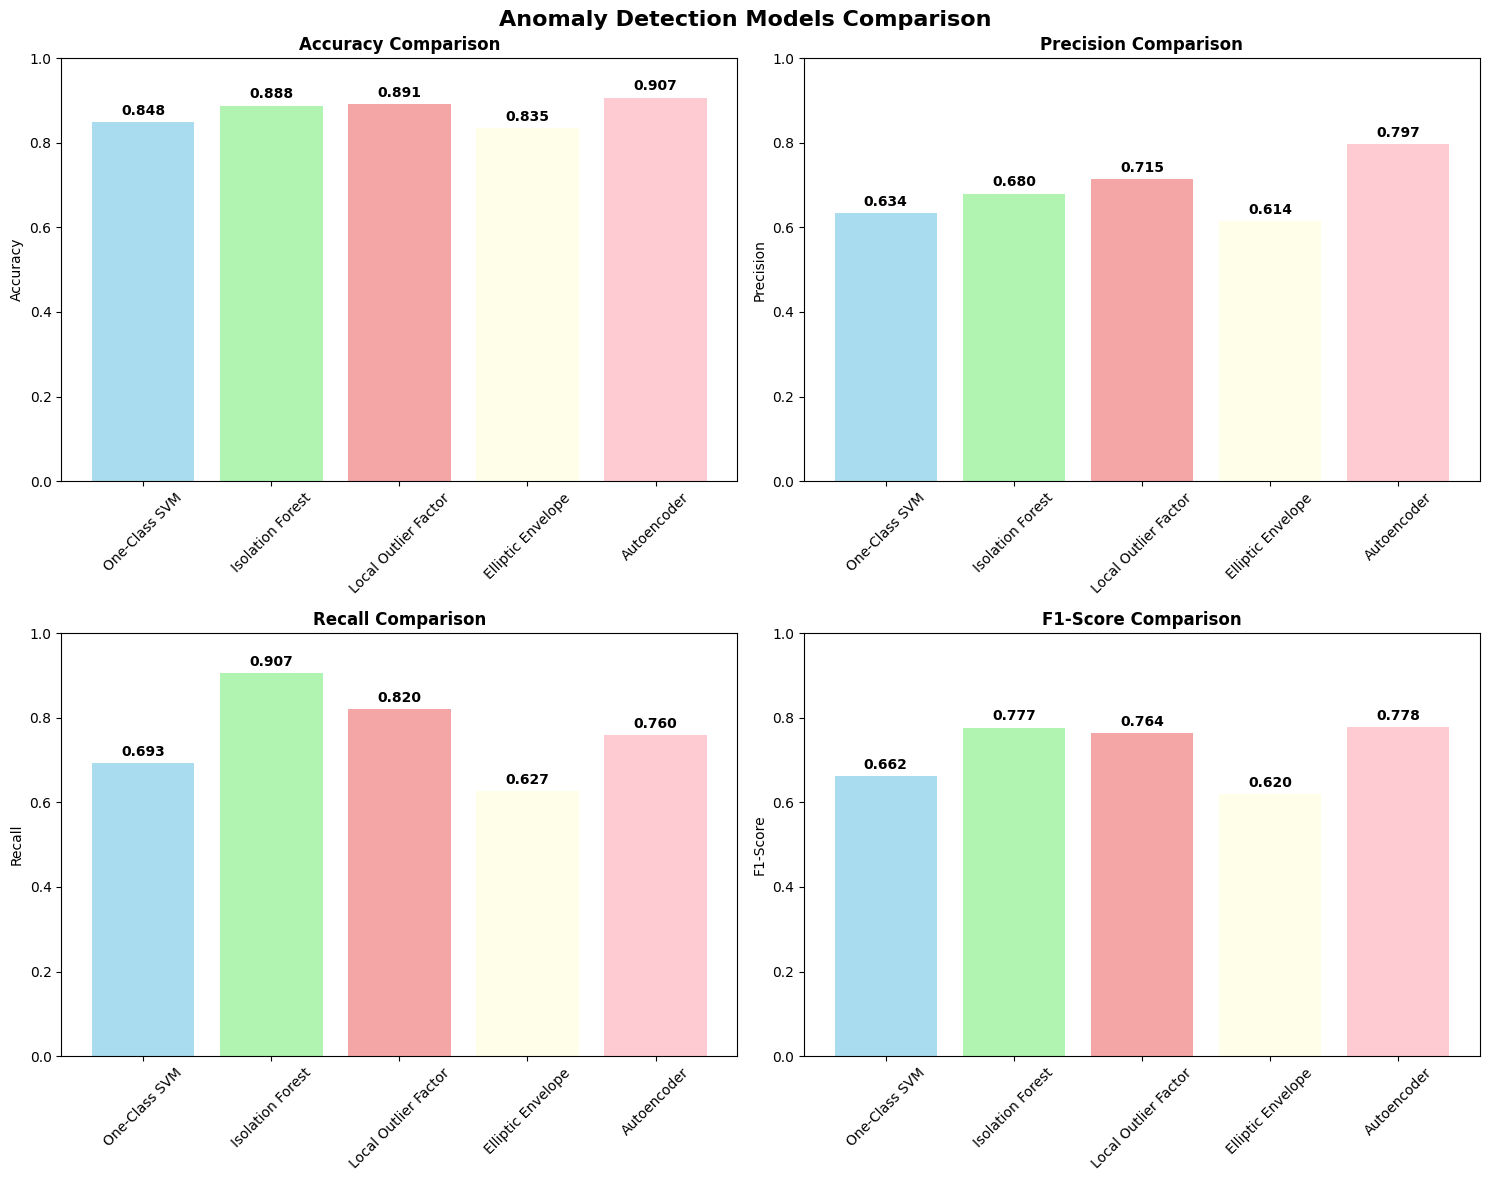

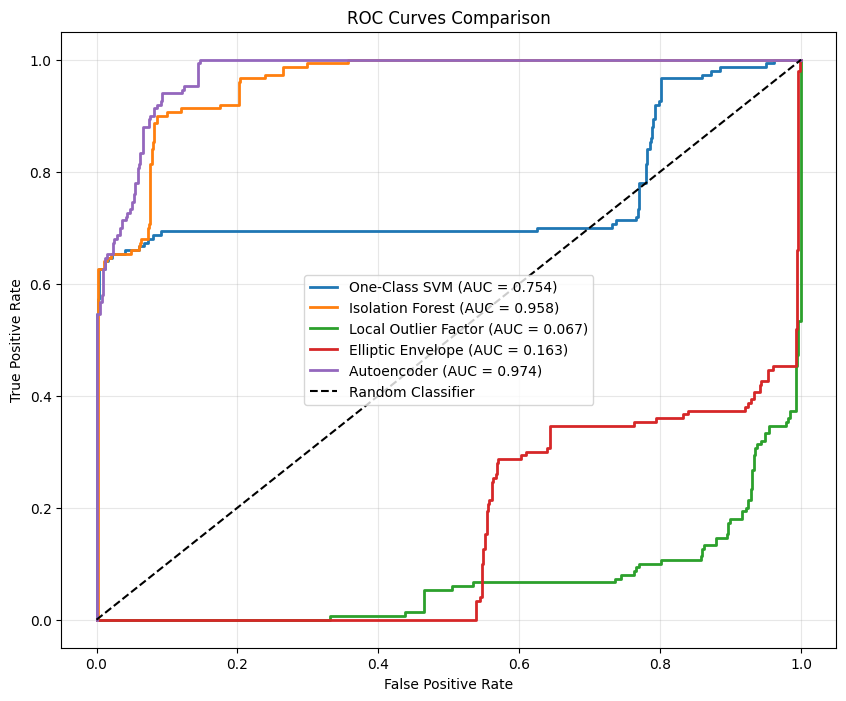

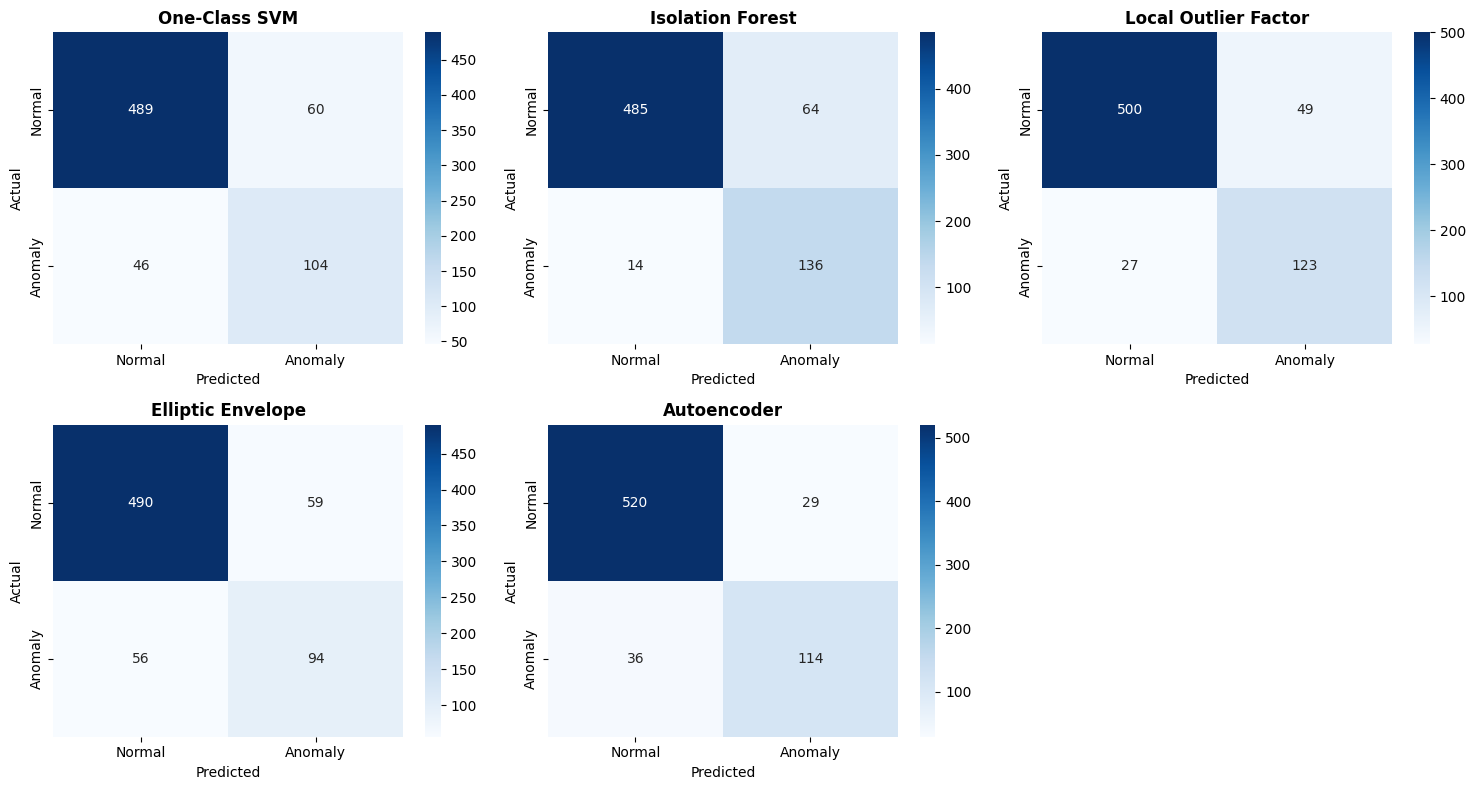

In [50]:
## 5. Results Visualization and Comparison

def plot_model_comparison(results):
    """Plot comparison of model performance"""
    if not results or all(v is None for v in results.values()):
        print("No results available for plotting.")
        return

    # Filter out None results
    valid_results = {k: v for k, v in results.items() if v is not None}

    if not valid_results:
        print("No valid results for plotting.")
        return

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Anomaly Detection Models Comparison', fontsize=16, fontweight='bold')

    # Metrics to plot
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

    for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
        ax = axes[idx // 2, idx % 2]

        models = list(valid_results.keys())
        values = [valid_results[model][metric] for model in models]

        bars = ax.bar(models, values, alpha=0.7,
                     color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightgray'][:len(models)])

        ax.set_title(f'{name} Comparison', fontweight='bold')
        ax.set_ylabel(name)
        ax.set_ylim(0, 1)

        # Add value labels on bars
        for bar, value in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

        # Rotate x-axis labels if needed
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def plot_roc_curves(results, predictions, X_test, y_test):
    """Plot ROC curves for models that support it"""
    if y_test is None:
        print("No ground truth available for ROC curves.")
        return

    plt.figure(figsize=(10, 8))

    for name, model in detector_comparison.models.items():
        if name in predictions and hasattr(model, 'decision_function') or hasattr(model, 'score_samples'):
            try:
                if hasattr(model, 'decision_function'):
                    scores = model.decision_function(X_test)
                    if name in ['One-Class SVM', 'Isolation Forest']:
                        scores = -scores  # Invert for proper interpretation
                elif hasattr(model, 'score_samples'):
                    scores = -model.score_samples(X_test)

                fpr, tpr, _ = roc_curve(y_test, scores)
                auc = roc_auc_score(y_test, scores)

                plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

            except Exception as e:
                print(f"Could not plot ROC for {name}: {e}")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def create_confusion_matrices(predictions, y_test):
    """Create confusion matrices for all models"""
    if y_test is None:
        print("No ground truth available for confusion matrices.")
        return

    n_models = len(predictions)
    if n_models == 0:
        return

    cols = min(3, n_models)
    rows = (n_models + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_models == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, (name, preds) in enumerate(predictions.items()):
        ax = axes[idx] if idx < len(axes) else None
        if ax is None:
            break

        cm = confusion_matrix(y_test, preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Normal', 'Anomaly'],
                   yticklabels=['Normal', 'Anomaly'])
        ax.set_title(f'{name}', fontweight='bold')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    # Hide unused subplots
    for idx in range(n_models, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

# Generate visualizations if we have results
if detector_comparison.results and y_test_full is not None:
    print("\n" + "=" * 60)
    print("VISUALIZATION AND ANALYSIS")
    print("=" * 60)

    # Plot model comparison
    plot_model_comparison(detector_comparison.results)

    # Plot ROC curves
    plot_roc_curves(detector_comparison.results, detector_comparison.predictions, X_test_scaled, y_test_full)

    # Create confusion matrices
    create_confusion_matrices(detector_comparison.predictions, y_test_full)

In [51]:
## 6. Model Selection and Recommendations

def analyze_results(results):
    """Analyze results and provide recommendations"""
    if not results or all(v is None for v in results.values()):
        print("No results available for analysis.")
        return

    print("\n" + "=" * 60)
    print("MODEL ANALYSIS AND RECOMMENDATIONS")
    print("=" * 60)

    # Filter out None results
    valid_results = {k: v for k, v in results.items() if v is not None}

    if not valid_results:
        print("No valid results for analysis.")
        return

    # Create a comprehensive comparison table
    df_results = pd.DataFrame(valid_results).T
    df_results = df_results.round(4)

    print("\nComprehensive Results Table:")
    print(df_results.to_string())

    # Find best models for different metrics
    print(f"\n{'Best Models by Metric:':<25}")
    print("-" * 40)

    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        if metric in df_results.columns:
            # Handle None values
            metric_data = df_results[metric].dropna()
            if not metric_data.empty:
                best_model = metric_data.idxmax()
                best_score = metric_data.max()
                print(f"{metric.capitalize():<15}: {best_model:<20} ({best_score:.4f})")

    # Overall recommendation based on F1-score (balance of precision and recall)
    if 'f1' in df_results.columns:
        f1_data = df_results['f1'].dropna()
        if not f1_data.empty:
            best_overall = f1_data.idxmax()
            print(f"\n{'RECOMMENDED MODEL:':<20} {best_overall}")
            print(f"{'Reason:':<20} Highest F1-score ({f1_data.max():.4f})")

            # Provide detailed analysis of the recommended model
            print(f"\n{best_overall} Detailed Performance:")
            best_metrics = valid_results[best_overall]
            for metric, value in best_metrics.items():
                if value is not None:
                    print(f"  {metric.capitalize():<12}: {value:.4f}")

    # Provide practical recommendations
    print(f"\n{'PRACTICAL RECOMMENDATIONS:'}")
    print("-" * 40)

    recommendations = []

    # High precision models
    if 'precision' in df_results.columns:
        precision_data = df_results['precision'].dropna()
        if not precision_data.empty:
            high_precision = precision_data[precision_data >= 0.8]
            if not high_precision.empty:
                recommendations.append(f"For low false positives: {', '.join(high_precision.index)}")

    # High recall models
    if 'recall' in df_results.columns:
        recall_data = df_results['recall'].dropna()
        if not recall_data.empty:
            high_recall = recall_data[recall_data >= 0.8]
            if not high_recall.empty:
                recommendations.append(f"For detecting most attacks: {', '.join(high_recall.index)}")

    # Balanced models
    if 'f1' in df_results.columns:
        f1_data = df_results['f1'].dropna()
        if not f1_data.empty:
            balanced = f1_data[f1_data >= 0.7]
            if not balanced.empty:
                recommendations.append(f"For balanced performance: {', '.join(balanced.index)}")

    for rec in recommendations:
        print(f"• {rec}")

    return df_results

# Analyze results
results_df = analyze_results(detector_comparison.results)


MODEL ANALYSIS AND RECOMMENDATIONS

Comprehensive Results Table:
                      accuracy  precision  recall      f1     auc
One-Class SVM           0.8484     0.6341  0.6933  0.6624  0.7538
Isolation Forest        0.8884     0.6800  0.9067  0.7771  0.9582
Local Outlier Factor    0.8913     0.7151  0.8200  0.7640  0.0668
Elliptic Envelope       0.8355     0.6144  0.6267  0.6205  0.1626
Autoencoder             0.9070     0.7972  0.7600  0.7782  0.9742

Best Models by Metric:   
----------------------------------------
Accuracy       : Autoencoder          (0.9070)
Precision      : Autoencoder          (0.7972)
Recall         : Isolation Forest     (0.9067)
F1             : Autoencoder          (0.7782)
Auc            : Autoencoder          (0.9742)

RECOMMENDED MODEL:   Autoencoder
Reason:              Highest F1-score (0.7782)

Autoencoder Detailed Performance:
  Accuracy    : 0.9070
  Precision   : 0.7972
  Recall      : 0.7600
  F1          : 0.7782
  Auc         : 0.9742

PRA

In [52]:
## 7. Hyperparameter Tuning for Best Model

def tune_best_model(best_model_name, X_train, X_test, y_test):
    """Perform hyperparameter tuning for the best model"""
    if y_test is None:
        print("No ground truth available for hyperparameter tuning.")
        return None

    print(f"\n{'HYPERPARAMETER TUNING'}")
    print("=" * 60)
    print(f"Tuning hyperparameters for: {best_model_name}")

    if best_model_name == 'One-Class SVM':
        param_grid = {
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
            'nu': [0.01, 0.05, 0.1, 0.2, 0.3]
        }
        base_model = OneClassSVM()

    elif best_model_name == 'Isolation Forest':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'contamination': [0.05, 0.1, 0.15, 0.2],
            'max_features': [1.0, 0.8, 0.6]
        }
        base_model = IsolationForest(random_state=42)

    elif best_model_name == 'Local Outlier Factor':
        param_grid = {
            'n_neighbors': [10, 20, 35, 50],
            'contamination': [0.05, 0.1, 0.15, 0.2],
            'algorithm': ['auto', 'ball_tree', 'kd_tree']
        }
        base_model = LocalOutlierFactor(novelty=True)

    else:
        print(f"Hyperparameter tuning not implemented for {best_model_name}")
        return None

    # Custom scorer for anomaly detection
    def anomaly_scorer(estimator, X, y):
        predictions = estimator.predict(X)
        if best_model_name in ['One-Class SVM', 'Isolation Forest', 'Local Outlier Factor']:
            predictions = (predictions == -1).astype(int)
        return f1_score(y, predictions)

    # Perform grid search
    print("Performing grid search...")

    try:
        # Create a custom scoring function
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring=anomaly_scorer,
            cv=3,
            n_jobs=-1,
            verbose=1
        )

        # Fit only on normal data for training
        X_train_normal_subset = X_train[y_test[:len(X_train)] == 0] if len(y_test) > len(X_train) else X_train
        grid_search.fit(X_train_normal_subset)

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        # Evaluate best model on test set
        best_model = grid_search.best_estimator_
        test_predictions = best_model.predict(X_test)

        if best_model_name in ['One-Class SVM', 'Isolation Forest', 'Local Outlier Factor']:
            test_predictions = (test_predictions == -1).astype(int)

        # Calculate metrics
        tuned_accuracy = accuracy_score(y_test, test_predictions)
        tuned_precision = precision_score(y_test, test_predictions, zero_division=0)
        tuned_recall = recall_score(y_test, test_predictions, zero_division=0)
        tuned_f1 = f1_score(y_test, test_predictions, zero_division=0)

        print(f"\nTuned Model Performance:")
        print(f"Accuracy:  {tuned_accuracy:.4f}")
        print(f"Precision: {tuned_precision:.4f}")
        print(f"Recall:    {tuned_recall:.4f}")
        print(f"F1-Score:  {tuned_f1:.4f}")

        return best_model

    except Exception as e:
        print(f"Error during hyperparameter tuning: {e}")
        return None

# Find the best model and tune it
if detector_comparison.results and y_test_full is not None:
    valid_results = {k: v for k, v in detector_comparison.results.items() if v is not None}
    if valid_results and 'f1' in pd.DataFrame(valid_results).T.columns:
        df_results = pd.DataFrame(valid_results).T
        best_model_name = df_results['f1'].idxmax()

        print(f"Performing hyperparameter tuning for best model: {best_model_name}")
        tuned_model = tune_best_model(best_model_name, X_train_scaled, X_test_scaled, y_test_full)

Performing hyperparameter tuning for best model: Autoencoder

HYPERPARAMETER TUNING
Tuning hyperparameters for: Autoencoder
Hyperparameter tuning not implemented for Autoencoder


In [53]:
## 8. Feature Importance Analysis

def analyze_feature_importance(model, feature_names, model_name):
    """Analyze feature importance for interpretable models"""
    print(f"\n{'FEATURE IMPORTANCE ANALYSIS'}")
    print("=" * 60)
    print(f"Analyzing feature importance for: {model_name}")

    try:
        # Different models have different ways to get feature importance
        if hasattr(model, 'feature_importances_'):
            # For tree-based models like Isolation Forest
            importances = model.feature_importances_

        elif hasattr(model, 'coef_'):
            # For linear models
            importances = np.abs(model.coef_[0])

        else:
            print(f"Feature importance not available for {model_name}")
            return

        # Create feature importance dataframe
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Most Important Features:")
        print(feature_importance_df.head(10).to_string(index=False))

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        top_features = feature_importance_df.head(10)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance Score')
        plt.title(f'Top 10 Feature Importance - {model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        return feature_importance_df

    except Exception as e:
        print(f"Error analyzing feature importance: {e}")
        return None

# Analyze feature importance for applicable models
feature_names = list(X.columns)
for name, model in detector_comparison.models.items():
    if name == 'Isolation Forest':  # This model supports feature importance
        analyze_feature_importance(model, feature_names, name)
        break


FEATURE IMPORTANCE ANALYSIS
Analyzing feature importance for: Isolation Forest
Feature importance not available for Isolation Forest
